In [ ]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

In [20]:
using LinearAlgebra
using ForwardDiff
using BlockDiagonals
using ControlSystems
using Plots
using Random; Random.seed!(12);

In [41]:
#Quaternion stuff
function hat(v)
    return [0 -v[3] v[2];
            v[3] 0 -v[1];
            -v[2] v[1] 0]
end
function L(q)
    s = q[1]
    v = q[2:4]
    L = [s    -v';
         v  s*I+hat(v)]
    return L
end
T = Diagonal([1; -ones(3)])
H = [zeros(1,3); I]
function qtoQ(q)
    return H'*T*L(q)*T*L(q)*H
end
function G(q)
    G = L(q)*H
end
function rptoq(ϕ)
    (1/sqrt(1+ϕ'*ϕ))*[1; ϕ]
end
function qtorp(q)
    q[2:4]/q[1]
end
function E(q)
    E = BlockDiagonal([1.0*I(3), G(q), 1.0*I(6)])
end

function quad_dynamics(x,u)
    r = x[1:3]
    q = x[4:7]/norm(x[4:7]) #normalize q just to be careful
    v = x[8:10]
    ω = x[11:13]
    Q = qtoQ(q)
    
    ṙ = Q*v
    q̇ = 0.5*L(q)*H*ω
    
    v̇ = Q'*[0; 0; -g] + (1/m)*[zeros(2,4); kt*ones(1,4)]*u - hat(ω)*v
    
    ω̇ = J\(-hat(ω)*J*ω + [0 ℓ*kt 0 -ℓ*kt; -ℓ*kt 0 ℓ*kt 0; km -km km -km]*u)
    
    return [ṙ; q̇; v̇; ω̇]
end
function quad_dynamics_rk4(x,u)
    #RK4 integration with zero-order hold on u
    f1 = quad_dynamics(x, u)
    f2 = quad_dynamics(x + 0.5*h*f1, u)
    f3 = quad_dynamics(x + 0.5*h*f2, u)
    f4 = quad_dynamics(x + h*f3, u)
    xn = x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
    xn[4:7] .= xn[4:7]/norm(xn[4:7]) #re-normalize quaternion
    return xn
end

quad_dynamics_rk4 (generic function with 1 method)

In [600]:
#Quadrotor parameters
m = 0.5
ℓ = 0.1750
J = Diagonal([0.0023, 0.0023, 0.004])
g = 9.81
kt=1.0
km=0.0245

h = 0.05 #20 Hz

Nx = 13     # number of states (quaternion)
Nx̃ = 12     # number of states (linearized)
Nu = 4     # number of controls
Tfinal = 5.0 # final time
Nt = Int(Tfinal/h)+1    # number of time steps
t_vec = h*(0:Nt-1)
thist = Array(range(0,h*(Nt-1), step=h));

# Cost weights
Q = Diagonal([10; 10; 10; 1; 1; 1; 1; 1; 1; 0.1; 0.1; 0.1]);
R = Array(I(Nu));

In [390]:
#Goal state
uhover = (m*g/4)*ones(4)
rg = [0.0; 0; 1.0]
qg = [1.0; 0; 0; 0]
vg = zeros(3)
ωg = zeros(3)
xg = [rg; qg; vg; ωg];

In [275]:
#Linearize dynamics about hover
A = ForwardDiff.jacobian(x->quad_dynamics_rk4(x,uhover),xg)
B = ForwardDiff.jacobian(u->quad_dynamics_rk4(xg,u),uhover);
Ã = Array(E(qg)'*A*E(qg))
B̃ = Array(E(qg)'*B);
function discrete_dynamics(params,x,u,k)
  Ã*x + B̃*u
end

discrete_dynamics (generic function with 1 method)

In [146]:
#LQR Controller
K = dlqr(Ã,B̃,Q,R)
#Feedback controller
function controller(x, k)
    
  q0 = x0[4:7]
  q = x[4:7]
  ϕ = qtorp(L(q0)'*q)
  
  Δx̃ = [x[1:3]-r0; ϕ; x[8:10]-v0; x[11:13]-ω0]
  
  u = uhover - K*Δx̃
end

controller (generic function with 2 methods)

ΔJ = 7.118436201380973e-6
iter     J           ΔJ        |d|         α        reg         ρ
---------------------------------------------------------------------
  1    2.279e+02   7.12e-06   0.00e+00  1.0000    1.00e-08    1.00e+00
convio = 0.018766475488170252
ΔJ = 0.0004318827498366318
  2    2.279e+02   4.32e-04   0.00e+00  1.0000    1.00e-08    1.00e+01
convio = 0.015040927533675558
ΔJ = 0.009145976620089868
  3    2.279e+02   9.15e-03   0.00e+00  1.0000    1.00e-08    1.00e+02
convio = 0.005221533170021618
ΔJ = 0.016426860391760556
  4    2.279e+02   1.64e-02   0.00e+00  1.0000    1.00e-08    1.00e+03
convio = 0.0012574098920035744
ΔJ = 0.010344471782019582
  5    2.279e+02   1.03e-02   0.00e+00  1.0000    1.00e-08    1.00e+04
convio = 0.00018429324929287538
ΔJ = 0.001990627424873992
  6    2.279e+02   1.99e-03   0.00e+00  1.0000    1.00e-08    1.00e+05
convio = 1.9312194619231383e-5


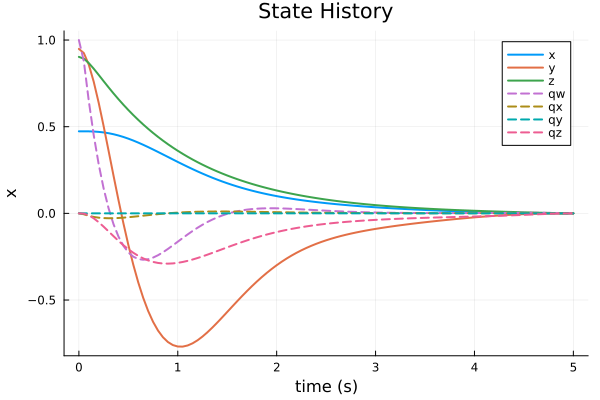

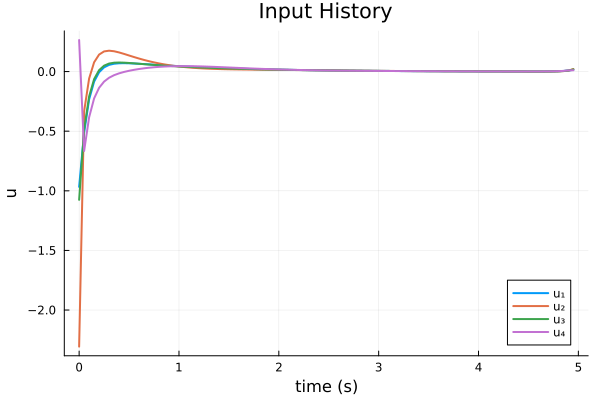

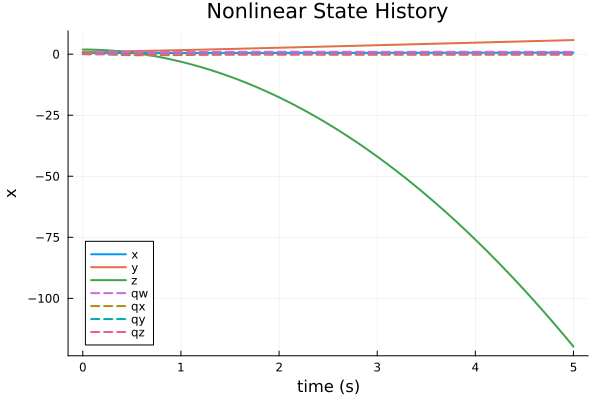

In [365]:
#Feedback hovering controller
include("tinyMPC.jl")
nx = Nx̃
nu = Nu
N = Nt
dt = h

Δx̃g = zeros(nx)
Xref = [deepcopy(Δx̃g) for i = 1:N]
Uref = [zeros(nu) for i = 1:N-1]

u_min = -1*uhover
u_max =  0.8*uhover

x_min = -100.0*ones(nx)
x_min[1:7] .= -.8
x_max = 100.0*ones(nx)
x_max[1:7] .= 1.0

max_inner_iters = 10  # MAX RICCATI SOLVING ITERATION
ncx = 2*nx*1
ncu = 2*nu*0
ncg = 1
ncu_cone = nu*0; 
cone_scale = 1e-3  # very fragile for each problem

μ = [zeros(ncu) for i = 1:N-1]   # input constraints
μx = [zeros(ncx) for i = 1:N]    # state constraints
λ = zeros(nx)    # goal constraint
λc = [zeros(ncu_cone) for i = 1:N-1]   # goal constraint
A_cone = [1 0 0; 0 1 0]
c_cone = [0.0, 0.0, tand(0)]

params = (
    nx = nx, nu = nu, ncx = ncx, ncu = ncu, ncg = ncg, ncu_cone = ncu_cone,
    μ = μ, μx = μx, λ = λ, λc = λc,
    A_cone = A_cone, c_cone = c_cone,
    N = N, Q = Q, R = R, Qf = 10*Q,
    u_min = u_min, u_max = u_max,
    x_min = x_min, x_max = x_max,
    Xref = Xref, Uref = Uref, dt = dt,
);

# previous MPC iterate
X = [zeros(nx) for i = 1:N]
U = [ones(nu) for k = 1:N-1]
# new MPC iterate
Xn = deepcopy(X)
Un = deepcopy(U)

P = [zeros(nx,nx) for i = 1:N]   # cost to go quadratic term
p = [zeros(nx) for i = 1:N]      # cost to go linear term
d = [zeros(nu) for i = 1:N-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:N-1] # feedback gain

x = [rg+rand(3); L(qg)*rptoq([1; 0; 0]); vg; ωg];
q = x[4:7]
ϕ = qtorp(L(qg)'*q)    
Δx̃ = [x[1:3]-rg; ϕ; x[8:10]-vg; x[11:13]-ωg]
X[1] .= Δx̃
u = mpc!(params,X,U,P,p,K,d,Xn,Un; atol=1e-4,max_iters=20,verbose=true,ρ=1e0,ρ_max=1e10, ϕ=10.0)

# Open-loop Simulation
xhist = zeros(Nx,N)
xhist[:,1] = x
for k = 1:(N-1)
    xhist[:,k+1] = quad_dynamics_rk4(xhist[:,k],Un[k])
end

# Plots
Xsim_m = mat_from_vec(Xn)
Usim_m = mat_from_vec(Un)
display(plot(t_vec,Xsim_m[1:7,:]',label=["x" "y" "z" "qw" "qx" "qy" "qz"],
linestyle=[:solid :solid :solid :dash :dash :dash :dash], linewidth=[2 2 2 2 2 2 2],
             title="State Solution", xlabel="time (s)", ylabel="x"))
display(plot(t_vec[1:end-1],Usim_m',label=["u₁" "u₂" "u₃" "u₄"],
             title="Input Solution", linewidth=[2 2 2 2 2 2 2],
             xlabel="time (s)", ylabel="u"))
display(plot(t_vec,xhist[1:7,:]',label=["x" "y" "z" "qw" "qx" "qy" "qz"],
linestyle=[:solid :solid :solid :dash :dash :dash :dash], linewidth=[2 2 2 2 2 2 2],
             title="Nonlinear State History", xlabel="time (s)", ylabel="x"))             

In [597]:
#Feedback tracking controller
include("tinyMPC.jl")
nx = Nx̃
nu = Nu
N = Nt
dt = h

# Δx̃g = zeros(nx)
# Xref = [deepcopy(Δx̃g) for i = 1:N]
Δx̃ref = [zeros(nx) for i = 1:Nt]
Uref = [zeros(nu) for i = 1:Nt-1]
Xref = [[5*cos(t);5*cos(t)*sin(t);1.2+sin(t);1;zeros(9)] for t = range(-pi/2, 3*pi/2 + 4*pi, length = Nt)]
for i = 1:Nt-1
    Xref[i][8:10] = (Xref[i+1][1:3] - Xref[i][1:3])/dt
end
for k = 1:Nt
    rref = Xref[k][1:3]
    qref = Xref[k][4:7]
    vref = Xref[k][8:10]
    ωref = Xref[k][10:12]
    ϕ = qtorp(L(qg)'*qref)    
    Δx̃ref[k] .= [-xg[1:3]+rref; ϕ; -xg[8:10]+vref; -xg[11:13]+ωref]
end
u_min = -uhover
u_max =  0.8*uhover

# state is x y v θ
x_min = -ones(nx)
x_max = ones(nx)

max_inner_iters = 10  # MAX RICCATI SOLVING ITERATION
ncx = 2*nx*0
ncu = 2*nu*0
ncg = 0
ncu_cone = nu*0; 
cone_scale = 1e-3  # very fragile for each problem

μ = [zeros(ncu) for i = 1:N-1]   # input constraints
μx = [zeros(ncx) for i = 1:N]    # state constraints
λ = zeros(nx)    # goal constraint
λc = [zeros(ncu_cone) for i = 1:N-1]   # goal constraint
A_cone = [1 0 0; 0 1 0]
c_cone = [0.0, 0.0, tand(0)]

params = (
    nx = nx, nu = nu, ncx = ncx, ncu = ncu, ncg = ncg, ncu_cone = ncu_cone,
    μ = μ, μx = μx, λ = λ, λc = λc,
    A_cone = A_cone, c_cone = c_cone,
    N = N, Q = 10*Q, R = R, Qf = 10*Q,
    u_min = u_min, u_max = u_max,
    x_min = x_min, x_max = x_max,
    Xref = Δx̃ref, Uref = Uref, dt = dt,
);

# previous MPC iterate
X = [zeros(nx) for i = 1:N]
U = [zeros(nu) for k = 1:N-1]
# new MPC iterate
Xn = deepcopy(X)
Un = deepcopy(U)

P = [zeros(nx,nx) for i = 1:N]   # cost to go quadratic term
p = [zeros(nx) for i = 1:N]      # cost to go linear term
d = [zeros(nu) for i = 1:N-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:N-1] # feedback gain

X[1] .= Δx̃ref[1]
u = mpc(params,X,U,P,p,K,d,Xn,Un; atol=1e-4,max_iters=20,verbose=true,ρ=1e0,ρ_max=1e10, ϕ=10.0)

# Open-loop Simulation
xhist = zeros(Nx,N)
xhist[:,1] = x
for k = 1:(N-1)
    xhist[:,k+1] = quad_dynamics_rk4(xhist[:,k],Un[k])
end

# Plots
Xsim_m = mat_from_vec(Xn)
Usim_m = mat_from_vec(Un)
display(plot(t_vec,Xsim_m[1:7,:]',label=["x" "y" "z" "qw" "qx" "qy" "qz"],
linestyle=[:solid :solid :solid :dash :dash :dash :dash], linewidth=[2 2 2 2 2 2 2],
             title="State Solution", xlabel="time (s)", ylabel="x"))
display(plot(t_vec[1:end-1],Usim_m',label=["u₁" "u₂" "u₃" "u₄"],
             title="Input Solution", linewidth=[2 2 2 2 2 2 2],
             xlabel="time (s)", ylabel="u"))
display(plot(t_vec,xhist[1:7,:]',label=["x" "y" "z" "qw" "qx" "qy" "qz"],
linestyle=[:solid :solid :solid :dash :dash :dash :dash], linewidth=[2 2 2 2 2 2 2],
             title="Nonlinear State History", xlabel="time (s)", ylabel="x"))   

LoadError: DimensionMismatch("second dimension of D, 1, does not match length of V, 12")

In [294]:
for k = 60:100
  @show norm(P[k] - P1[k])
end

norm(P[k] - P1[k]) = 2.4184352179426412e-12
norm(P[k] - P1[k]) = 2.257933700792851e-12
norm(P[k] - P1[k]) = 2.063297080232964e-12
norm(P[k] - P1[k]) = 1.7184441785873941e-12
norm(P[k] - P1[k]) = 1.5287097740717942e-12
norm(P[k] - P1[k]) = 1.5384795297594321e-12
norm(P[k] - P1[k]) = 1.5266378073933736e-12
norm(P[k] - P1[k]) = 1.3358310283879037e-12
norm(P[k] - P1[k]) = 1.0421023643775044e-12
norm(P[k] - P1[k]) = 1.0185445006383322e-12
norm(P[k] - P1[k]) = 7.848539094856739e-13
norm(P[k] - P1[k]) = 7.302706842157818e-13
norm(P[k] - P1[k]) = 4.997252423957722e-13
norm(P[k] - P1[k]) = 4.4358996387513027e-13
norm(P[k] - P1[k]) = 5.370004907448712e-13
norm(P[k] - P1[k]) = 6.036719769813565e-13
norm(P[k] - P1[k]) = 3.4569128272044086e-13
norm(P[k] - P1[k]) = 2.092631359388908e-13
norm(P[k] - P1[k]) = 2.2899109024804635e-13
norm(P[k] - P1[k]) = 1.737573160233491e-13
norm(P[k] - P1[k]) = 2.784791429373904e-13
norm(P[k] - P1[k]) = 1.9496008037886268e-13
norm(P[k] - P1[k]) = 1.2109002295887863e-1

In [792]:
#Feedback tracking controller
include("tinyMPC.jl")
nx = Nx̃
nu = Nu
N = 21
dt = h
Tfinal = 10.0 # final time
Nt = Int(Tfinal/h)+1    # number of time steps
t_vec = h*(0:Nt-1)

#Create trajectory to follow
# Δx̃g = zeros(nx)
# Xref = [deepcopy(Δx̃g) for i = 1:N]
Δx̃ref = [zeros(nx) for i = 1:Nt+N]
Uref = [zeros(nu) for i = 1:Nt+N-1]
Xref = [[5*cos(t);5*cos(t)*sin(t);1.2;1;zeros(9)] for t = range(0, 2*pi + pi/4, length = Nt+N)]  # Number-eight
# Xref = [[0.1*t;0.1*t;1;1;zeros(9)] for t = 1:Nt+N]  # Straight
# scale = 40.0
# for k = 1:Nt+N  # Triangle
#     if k < (Nt+N)/3
#         Xref[k][1:2] .= [2*k; k]/scale
#     elseif k < 2*(Nt+N)/3
#         k1 = k - (Nt+N)/3
#         Xref[k][1:2] .= [2*(Nt+N)/3 + 2*k1; (Nt+N)/3 - k1]/scale
#     else 
#         k1 = k - 2*(Nt+N)/3
#         Xref[k][1:2] .= [2*(Nt+N)/3 - 2*k1; 0.0]/scale
#     end
# end
for i = 1:Nt+N-1
    Xref[i][8:10] = (Xref[i+1][1:3] - Xref[i][1:3])/dt
end
for k = 1:Nt+N
    x = Xref[k]
    q = x[4:7]
    ϕ = qtorp(L(qg)'*q)   
    Δx̃ref[k] .= [x[1:3]-rg; ϕ; x[8:10]-vg; x[11:13]-ωg]
end

u_min = -uhover
u_max =  0.8*uhover

# state is x y v θ
x_min = -ones(nx)
x_max = ones(nx)

max_inner_iters = 10  # MAX RICCATI SOLVING ITERATION
ncx = 2*nx*0
ncu = 2*nu*1
ncg = 0
ncu_cone = nu*0; 
cone_scale = 1e-3  # very fragile for each problem

μ = [zeros(ncu) for i = 1:N-1]   # input constraints
μx = [zeros(ncx) for i = 1:N]    # state constraints
λ = zeros(nx)    # goal constraint
λc = [zeros(ncu_cone) for i = 1:N-1]   # goal constraint
A_cone = [1 0 0; 0 1 0]
c_cone = [0.0, 0.0, tand(0)]

params = (
    nx = nx, nu = nu, ncx = ncx, ncu = ncu, ncg = ncg, ncu_cone = ncu_cone,
    μ = μ, μx = μx, λ = λ, λc = λc,
    A_cone = A_cone, c_cone = c_cone,
    N = N, Q = 10*Q, R = R, Qf = 10*Q,
    u_min = u_min, u_max = u_max,
    x_min = x_min, x_max = x_max,
    Xref = Δx̃ref, Uref = Uref, dt = dt,
);

# previous MPC iterate
X = [zeros(nx) for i = 1:N]
U = [zeros(nu) for k = 1:N-1]
# new MPC iterate
Xn = deepcopy(X)
Un = deepcopy(U)

P = [zeros(nx,nx) for i = 1:N]   # cost to go quadratic term
p = [zeros(nx) for i = 1:N]      # cost to go linear term
d = [zeros(nu) for i = 1:N-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:N-1] # feedback gain

function controller_mpc(params, x, k)
    q = x[4:7]
    ϕ = qtorp(L(qg)'*q)
    
    Δx̃ = [x[1:3]-rg; ϕ; x[8:10]-vg; x[11:13]-ωg]
    X[1] .= Δx̃
    u = mpc(params,X,U,P,p,K,d,Xn,Un; atol=1e-2,max_iters=20,verbose=false,ρ=1e0,ρ_max=1e6, ϕ=10.0)
    return u + uhover
end

controller_mpc (generic function with 2 methods)

In [793]:
#Simulation
uhist = zeros(Nu,Nt-1)
xhist = zeros(Nx,Nt)
# xhist[:,1] = [rg+randn(3); L(qg)*rptoq([1; 0; 0]); vg; ωg]  # initial conditions
xhist[:,1] .= Xref[1]
for k = 1:(Nt-1)
    params1 = (; params..., Uref = Uref[k:N+k-1], Xref = Δx̃ref[k:N+k])  # update ref
    uhist[:,k] = controller_mpc(params1, xhist[:,k], k)
    xhist[:,k+1] = quad_dynamics_rk4(xhist[:,k],uhist[:,k])
end

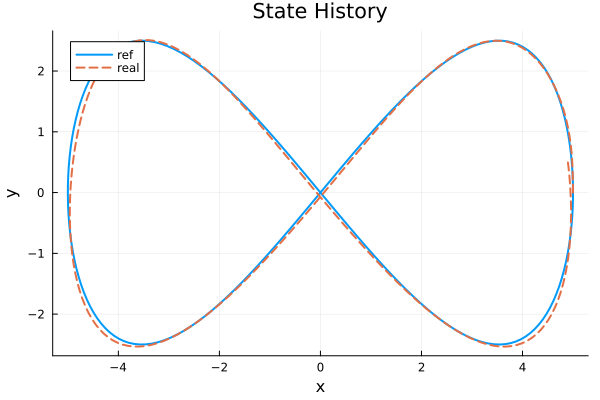

In [794]:
Xsim_m = mat_from_vec(Xref[1:Nt])
plot(Xsim_m[1,:],Xsim_m[2,:],label="ref",
linestyle=:solid, linewidth=2,
             title="State History", xlabel="x", ylabel="y")
          
display(plot!(xhist[1,:],xhist[2,:],label="real", linestyle=:dash, linewidth=2,
             title="State History", xlabel="x", ylabel="y"))

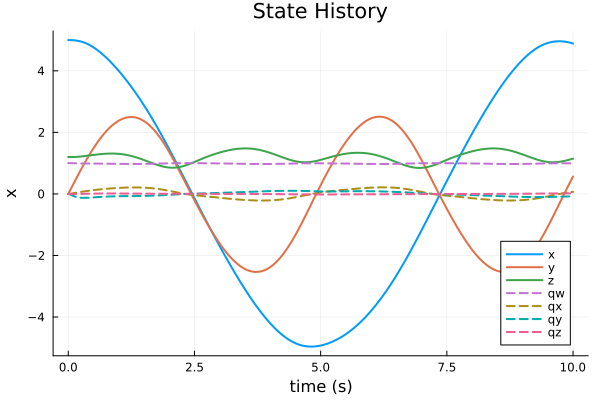

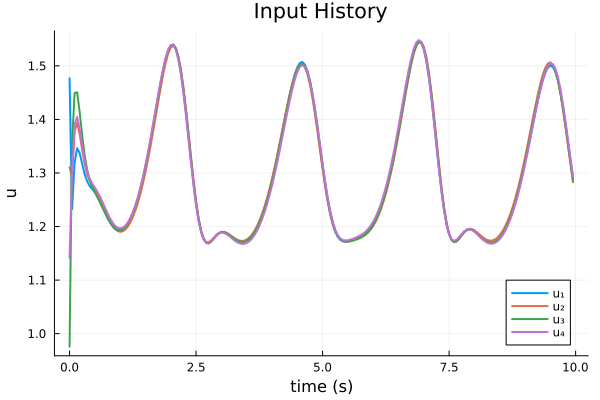

In [795]:
using Plots
display(plot(t_vec,xhist[1:7,:]',label=["x" "y" "z" "qw" "qx" "qy" "qz"],
linestyle=[:solid :solid :solid :dash :dash :dash :dash], linewidth=[2 2 2 2 2 2 2],
             title="State History", xlabel="time (s)", ylabel="x"))
display(plot(t_vec[1:end-1],uhist',label=["u₁" "u₂" "u₃" "u₄"],
             title="Input History", linewidth=[2 2 2 2 2 2 2],
             xlabel="time (s)", ylabel="u"))

In [289]:
#Set up visualization
using TrajOptPlots
using MeshCat
using StaticArrays
using RobotZoo:Quadrotor

vis = Visualizer()
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8705
└ @ MeshCat /home/khai/.julia/packages/MeshCat/GlCMx/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), Set{Any}(), ip"127.0.0.1", 8705))

In [380]:
model = Quadrotor()
TrajOptPlots.set_mesh!(vis, model)

false

In [777]:
X1 = [SVector{13}(x) for x in eachcol(xhist)];
visualize!(vis, model, t_vec[end], X1)